In [1]:
import tensorflow as tf
import numpy as np
import cv2
import base64
import io
import json
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten
from tensorflow.keras.layers import Dense, Reshape, Input, BatchNormalization
from tensorflow.data import Dataset
from PIL import Image
from keras.models import load_model
from prepare_img import preprocessing_fun


IMAGE_SHAPE = (70,70)
batch_size = 64
tf.random.set_seed(10)
l2_lambda = 0.0001 

In [2]:
img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    preprocessing_function = preprocessing_fun,
    validation_split=0.25
)

In [3]:
training_gen = img_datagen.flow_from_directory(
    'TRAIN',
    target_size=IMAGE_SHAPE,
    color_mode='grayscale',
    batch_size=batch_size,
    shuffle=True,
    seed=10,
    subset="training"
)
validation_gen = img_datagen.flow_from_directory(
    'TRAIN',
    target_size=IMAGE_SHAPE,
    color_mode='grayscale',
    batch_size=batch_size,
    shuffle=True,
    seed=10,
    subset="validation"
)

Found 12022 images belonging to 33 classes.
Found 3992 images belonging to 33 classes.


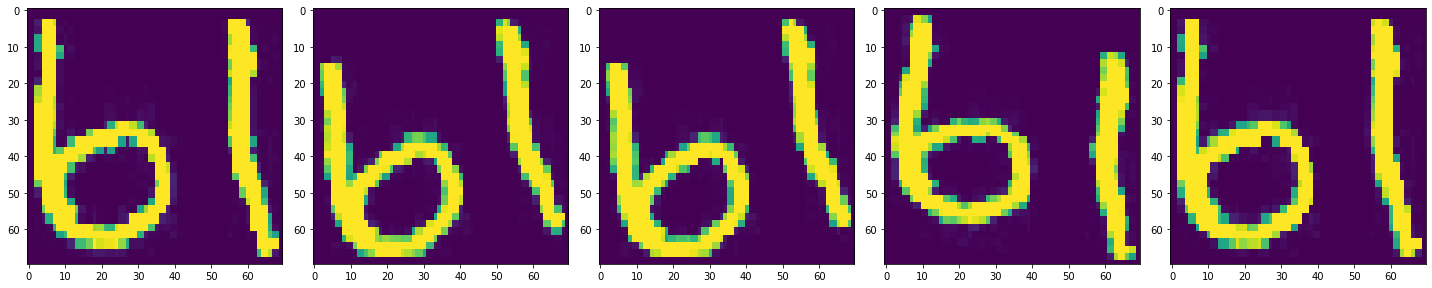

In [4]:
augmented_images = [training_gen[0][0][0] for i in range(5)]

fig, axes = plt.subplots(1, 5, figsize=(20,20))
axes = axes.flatten()
for img, ax in zip( augmented_images, axes):
        ax.imshow(img.astype('uint8'))
plt.tight_layout()
plt.show()

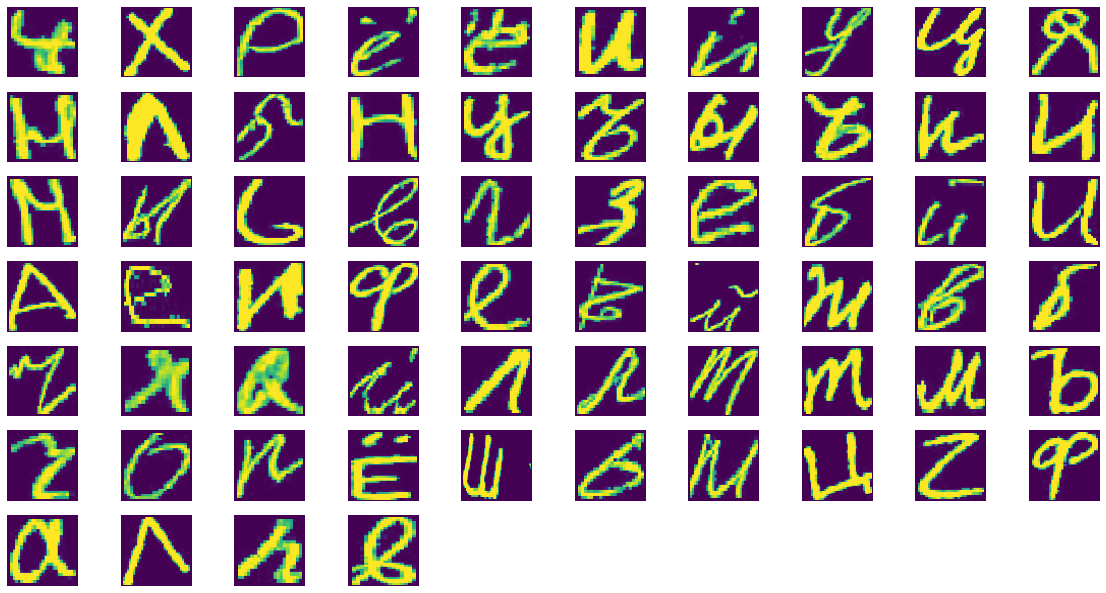

In [5]:
plt.figure(figsize=(20, 20))
def show_images(train_ds, class_names, n = 9):
    images, labels = train_ds[2]
    for i in range(64):
        ax = plt.subplot(13, 10, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.axis("off")
show_images(training_gen, np.array(set(training_gen.labels)))

In [6]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(*IMAGE_SHAPE, 1))
]

In [7]:
def conv_2d_pooling_layers(filters, drop_prob):
    return [
        tf.keras.layers.Conv2D(
            filters,
            (4,4),
            activation='relu',
            padding='same',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(drop_prob),
    ]

core_layers = \
    conv_2d_pooling_layers(32, 0.25) + \
    conv_2d_pooling_layers(64, 0.25) + \
    conv_2d_pooling_layers(128, 0.5)

In [8]:
dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, kernel_initializer='he_uniform', 
                          activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
    tf.keras.layers.BatchNormalization(axis=1),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(33, kernel_initializer='glorot_uniform', activation='softmax')
]

In [9]:
model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 70, 70, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 70, 70, 32)        544       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 35, 35, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 35, 35, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 35, 35, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 64)       0         
 2D)                                                    

2022-02-11 18:32:56.337383: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-11 18:32:56.337446: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mj-i511k-nikolaevskaya): /proc/driver/nvidia/version does not exist
2022-02-11 18:32:56.338290: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

In [11]:
history = model.fit(
    training_gen,
    steps_per_epoch=int(np.ceil(training_gen.n / float(batch_size))),
    validation_data = validation_gen,
    validation_steps=int(np.ceil(validation_gen.n / float(batch_size))),
    epochs = 50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
188/188 [==============================] - 65s 339ms/step - loss: 1.9524 - accuracy: 0.5028 - val_loss: 1.5897 - val_accuracy: 0.6941
Epoch 2/50
188/188 [==============================] - 62s 327ms/step - loss: 1.0671 - accuracy: 0.7348 - val_loss: 0.8923 - val_accuracy: 0.7958
Epoch 3/50
188/188 [==============================] - 61s 325ms/step - loss: 0.8645 - accuracy: 0.7932 - val_loss: 0.7716 - val_accuracy: 0.8337
Epoch 4/50
188/188 [==============================] - 62s 328ms/step - loss: 0.7771 - accuracy: 0.8223 - val_loss: 0.7340 - val_accuracy: 0.8399
Epoch 5/50
188/188 [==============================] - 53s 280ms/step - loss: 0.7065 - accuracy: 0.8485 - val_loss: 0.6390 - val_accuracy: 0.8725
Epoch 6/50
188/188 [==============================] - 46s 245ms/step - loss: 0.6555 - accuracy: 0.8635 - val_loss: 0.6717 - val_accuracy: 0.8707
Epoch 7/50
188/188 [==============================] - 44s 232ms/step - loss: 0.6460 - accuracy: 0.8712 - val_loss: 0.6660 - val_ac

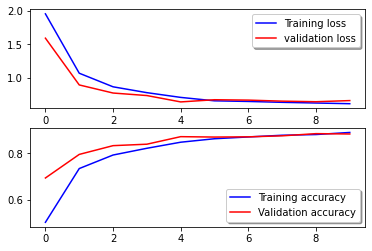

In [12]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [13]:
model.save('weight/20-epoch')

2022-02-11 18:41:42.315638: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: weight/20-epoch/assets
